<a href="https://colab.research.google.com/github/renhaa/faces/blob/master/DownloadDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/My\ Drive/faces

In [0]:
%run Tools.ipynb

import matplotlib.pyplot as plt
import numpy as np
import urllib
import cv2
from tqdm import tqdm, tqdm_notebook
from PIL import Image
import requests
from io import BytesIO
import json
from PIL import Image
import glob

# Prepare FFHQ 128x128 thumbnails. 

In [0]:
!rm -r data/ffhq/
!mkdir data/ffhq/
!wget -P ffhq/ https://raw.githubusercontent.com/NVlabs/ffhq-dataset/master/download_ffhq.py
!python ffhq/download_ffhq.py -j
!mv ffhq-dataset-v2.json data/ffhq/



--2019-11-06 19:30:46--  https://raw.githubusercontent.com/NVlabs/ffhq-dataset/master/download_ffhq.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20653 (20K) [text/plain]
Saving to: ‘ffhq/download_ffhq.py’

download_ffhq.py    100%[===================>]  20.17K  --.-KB/s    in 0.001s  

2019-11-06 19:30:46 (14.9 MB/s) - ‘ffhq/download_ffhq.py’ saved [20653/20653]

Parsing JSON metadata...


shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


In [0]:

json_file = "data/ffhq/ffhq-dataset-v2.json"
with open(json_file, 'r') as f:
    data = json.load(f)



In [0]:


n = 1000
X = np.zeros((n,128,128,3))
for i in tqdm(range(n)):
  url = data[str(i)]['thumbnail']['file_url'] 

  try:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = np.array(img)

    img = img / 255
    X[i,:,:,:] = img
    l = [img]  
  except:
    print(f"Warning i={i} url: {url}")
np.random.shuffle(X)
np.save(f"data/ffhq/ffhq-{n}-thumbs",X)



  5%|▌         | 271/5000 [02:53<4:25:30,  3.37s/it]

Warning i=270 url: https://drive.google.com/uc?id=1vUW2vvkQMynUcWN8Jmc6fNU__ur6OV1Z


  6%|▌         | 288/5000 [03:01<37:20,  2.10it/s]

Warning i=287 url: https://drive.google.com/uc?id=1w0Nh2aYdTneTuYGoV1lIbfZ4cRJPFllC


 56%|█████▌    | 2775/5000 [37:30<2:09:36,  3.50s/it]

Warning i=2774 url: https://drive.google.com/uc?id=1nft8JWq7TGr5AmMWBwUlli2X1IsvPzqT


 96%|█████████▋| 4814/5000 [1:08:51<30:26,  9.82s/it]

Warning i=4813 url: https://drive.google.com/uc?id=1HI-pueD5WgDjZS_vT5k2q4U3f5V1s_V1


100%|██████████| 5000/5000 [1:11:50<00:00,  1.28s/it]


Saved to: results/data/ffhq.png


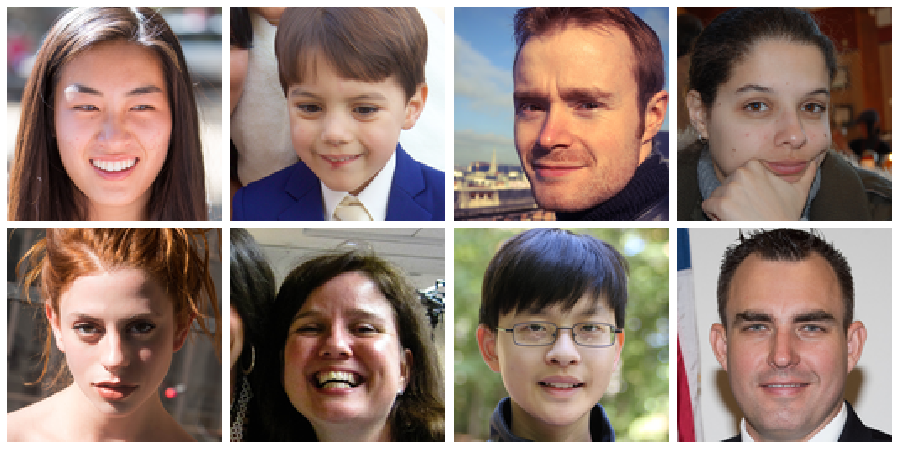

In [0]:
# !rm -r results/data/
# !mkdir results/data/
X = np.load("data/ffhq/ffhq-1000-thumbs.npy")
np.random.shuffle(X)
plot_images(X,  nr = 8,figsize=(16,8) ,dim=(2,4), fname = f"results/data/ffhq.png")

# Prepare caltech

In [0]:
!rm -r data/caltech/
!mkdir data/caltech/
!wget faces.tar http://www.vision.caltech.edu/Image_Datasets/faces/faces.tar
!tar -xf faces.tar -C data/caltech/
!rm faces.tar


--2019-11-15 17:34:17--  http://faces.tar/
Resolving faces.tar (faces.tar)... failed: Name or service not known.
wget: unable to resolve host address ‘faces.tar’
--2019-11-15 17:34:17--  http://www.vision.caltech.edu/Image_Datasets/faces/faces.tar
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75130880 (72M) [application/x-tar]
Saving to: ‘faces.tar.1’

faces.tar.1         100%[===================>]  71.65M  9.86MB/s    in 8.3s    

2019-11-15 17:34:25 (8.63 MB/s) - ‘faces.tar.1’ saved [75130880/75130880]

FINISHED --2019-11-15 17:34:25--
Total wall clock time: 8.7s
Downloaded: 1 files, 72M in 8.3s (8.63 MB/s)


In [0]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2019-11-15 17:58:23--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.08s   

2019-11-15 17:58:23 (11.8 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [0]:

def crop_image(img,rect):
    (x,y,w,h) = rect
    return img[y:y+h, x:x+w]

img_size = 128
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

filenames = glob.glob('data/caltech/*.jpg')
X = np.zeros((len(filenames),img_size,img_size,3))
bad_index = []
for i, filename in tqdm_notebook(enumerate(filenames)): 
    img = Image.open(filename)
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
   
    if len(faces) > 0:
        crop_img = crop_image(img,faces[0])
        resized = cv2.resize(crop_img, (img_size,img_size), interpolation = cv2.INTER_AREA)

        img = resized / 255
       
        X[i,:,:,:] = img
    else:
        print("Warning no face found",filename)
        bad_index.append(i)
X = np.delete(X,bad_index,axis=0)
print("Final_shape:", X.shape)
np.random.shuffle(X)
np.save("data/caltech/caltech.npy",X)


Warning no face found data/caltech/image_0016.jpg
Warning no face found data/caltech/image_0015.jpg
Warning no face found data/caltech/image_0071.jpg
Warning no face found data/caltech/image_0135.jpg
Warning no face found data/caltech/image_0190.jpg
Warning no face found data/caltech/image_0195.jpg
Warning no face found data/caltech/image_0265.jpg
Warning no face found data/caltech/image_0298.jpg
Warning no face found data/caltech/image_0327.jpg
Warning no face found data/caltech/image_0325.jpg
Warning no face found data/caltech/image_0321.jpg
Warning no face found data/caltech/image_0403.jpg
Warning no face found data/caltech/image_0402.jpg
Warning no face found data/caltech/image_0400.jpg
Final_shape: (436, 128, 128, 3)


Saved to: results/data/caltech.png


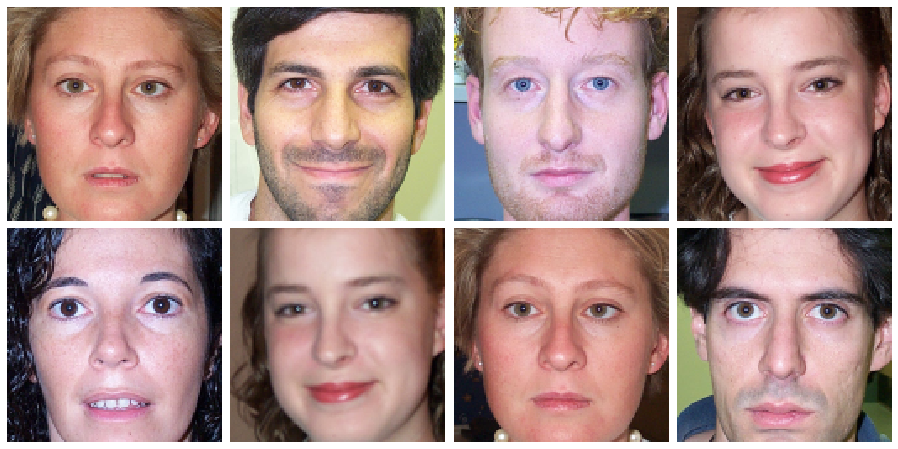

In [0]:
X = np.load("data/caltech/caltech.npy")
# X = grayscale(X)
plot_images(X,nr = 8,figsize=(16,8) ,dim=(2,4), fname = f"results/data/caltech.png")

/bin/bash: google-drive-ocamlfuse: command not found
